# A. Importation of libraries and Configs

In [1]:
# Standard libraries
import pandas as pd
from datetime import datetime

In [2]:
class Config:
    # Path to the pseudonimized revenues dataset
    dataset_dir = r"Database\revenues_pseudonymized.xlsx"
    # Path to the enrollee infos
    enrollees_dir = r"Database\enrollees_pseudonymized.xlsx"
    # Path to the machine learning model parameters
    parameters_dir = r"MachineLearning\parameters.json"

    # Path to cache directory to store preprocessed dataset if needed
    cache_dir = ""
    load_cache = True

    # Path to store transformer results
    results_dir = r"C:\Users\rjbel\Python\Data\Thesis\Results"


    # The date used
    observation_end = datetime.today()

    # Class to predict
    target_feature = 'dtp_bracket'
    # Test size in %
    test_size = 0.3

    # Time points used in generating survival features
    # It's not until 120 since the earliest pre-payment is 288 days
    time_points = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450]


args = Config()

# B. Loading of datasets

## 1. Revenues

In [3]:
df_revenues = pd.read_excel(args.dataset_dir)

In [4]:
df_revenues

,entry_number,entry_date,due_date,school_year,student_id_pseudonimized,category_name,discount_refund_applied_to,amount_due,amount_paid,account_name,receivables
0,0,2025-10-13,2025-10-13,2014,9XBPS6GQ,Form 137,NaN,150.0,150.0,G-Cash,0.0
1,1,2016-01-01,2016-01-01,2016,QCNXOF71,Back Account,NaN,3524.0,0.0,Not Applicable,3524.0
2,2,2016-01-01,2016-01-01,2016,UFN5RBCA,Back Account,NaN,9831.0,0.0,Not Applicable,9831.0
3,3,2016-01-01,2016-01-01,2016,CATF26JR,Back Account,NaN,9240.0,0.0,Not Applicable,9240.0
4,4,2016-01-01,2016-01-01,2016,TE11Z2LJ,Back Account,NaN,5886.0,0.0,Not Applicable,5886.0
...,...,...,...,...,...,...,...,...,...,...,...
51603,53726,2026-02-25,2026-08-07,2026,JQ7PB94W,G02-B-1st,NaN,7500.0,0.0,Not Applicable,7500.0
51604,53727,2026-02-25,2026-11-06,2026,JQ7PB94W,G02-B-2nd,NaN,7500.0,0.0,Not Applicable,7500.0
51605,53728,2026-02-25,2026-08-07,2026,JQ7PB94W,G02-OF-1st,NaN,5467.0,5467.0,Bank,0.0
51606,53729,2026-02-25,2026-12-04,2026,JQ7PB94W,G02-OF-2nd,NaN,5467.0,0.0,Not Applicable,5467.0


## 2. Enrollees

In [5]:
df_enrollees = pd.read_excel(args.enrollees_dir)

## 3. Credit Sales

In [6]:
from FeatureEngineering.credit_sales_machine_learning import CreditSales

cs = CreditSales(df_revenues, df_enrollees, args)
df_credit_sales = cs.show_data()

Single due date records: 10075
Multiple due date records: 254


c:\Users\rjbel\Python\Notebooks\Mapua\Thesis\FeatureEngineering\credit_sales_machine_learning.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return trend.fillna(0)
c:\Users\rjbel\Python\Notebooks\Mapua\Thesis\FeatureEngineering\credit_sales_machine_learning.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return trend.fillna(0)
c:\Users\rjbel\Python\Notebooks\Mapua\Thesis\FeatureEngineering\credit_sales_machine_learning.py:703: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [7]:
df_credit_sales

,school_year,student_id_pseudonimized,category_name,gross_receivables,amount_discounted,adjustments,credit_sale_amount,due_date,date_fully_paid,days_elapsed_until_fully_paid,...,amount_paid_cumsum,opening_balance,plan_type_Plan - A,plan_type_Plan - B,plan_type_Plan - C,plan_type_Plan - D,plan_type_Plan - E,plan_type_nan,dtp_bracket,censor
0,2016,QCNXOF71,Back Account,3524.0,0.0,0.0,3524.0,2016-01-01,2019-01-31,1126,...,0.0,3524.0,0.0,0.0,0.0,0.0,0.0,1.0,90_days,1
1,2016,TE11Z2LJ,Back Account,5886.0,0.0,0.0,5886.0,2016-01-01,2019-03-11,1165,...,0.0,5886.0,0.0,0.0,0.0,0.0,0.0,1.0,90_days,1
2,2016,LI5DFHZ5,Back Account,5650.0,0.0,0.0,5650.0,2016-01-01,2021-01-29,1855,...,0.0,5650.0,0.0,0.0,0.0,0.0,0.0,1.0,90_days,1
3,2016,UFN5RBCA,Back Account,9831.0,0.0,0.0,9831.0,2016-01-01,2019-04-26,1211,...,0.0,9831.0,0.0,0.0,0.0,0.0,0.0,1.0,90_days,1
4,2016,CATF26JR,Back Account,9240.0,0.0,0.0,9240.0,2016-01-01,2019-02-06,1132,...,0.0,9240.0,0.0,0.0,0.0,0.0,0.0,1.0,90_days,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10176,2026,D9L1401L,G06-OF-Full,10000.0,0.0,0.0,10000.0,2026-07-11,2026-01-31,-161,...,230000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,on_time,1
10177,2026,XO7E9JLP,G09-OF-Full,800.0,0.0,0.0,800.0,2026-07-11,2026-01-16,-176,...,345984.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,on_time,1
10178,2026,L1RIQ6A4,G02-A-UE,15600.0,-3680.0,0.0,11920.0,2026-07-11,2026-01-26,-166,...,248238.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,on_time,1
10179,2026,5NX2Y86F,G09-OF-Full,18800.0,0.0,0.0,18800.0,2026-07-11,2026-02-02,-159,...,338521.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,on_time,1


# C. Exploratory Data Analysis

In [8]:
# Get counts
counts = df_credit_sales.dtp_bracket.value_counts()

# Convert to percentages
percentages = counts / counts.sum() * 100

# Combine into one DataFrame
result = pd.DataFrame({
    'count': counts,
    'percentage': percentages.round(2)
})

print(result)

             count  percentage
dtp_bracket                   
on_time       3735       39.99
30_days       2751       29.45
90_days       1805       19.32
60_days       1050       11.24


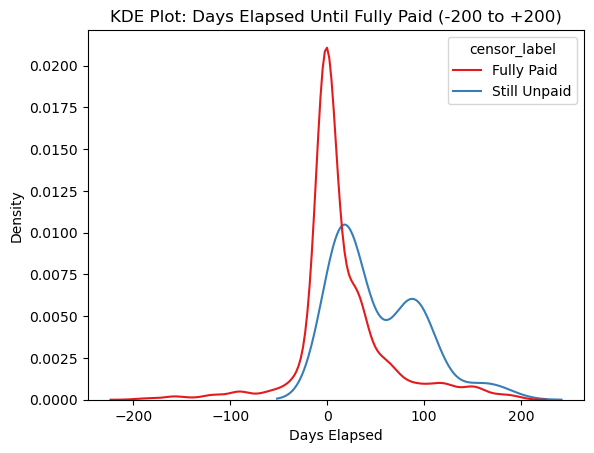

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Remove those that have no full dtp_history:
df_filtered = df_credit_sales.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4'])


# Clean and filter directly on the DataFrame
df_filtered = df_filtered.loc[
    df_filtered['days_elapsed_until_fully_paid']
        .replace("", np.nan)   # replace empty strings with NaN
        .dropna()              # drop NaNs
        .index                 # keep aligned index
]


# Apply numeric filter
df_filtered = df_filtered[
    (df_filtered['days_elapsed_until_fully_paid'] >= -200) &
    (df_filtered['days_elapsed_until_fully_paid'] <= 200)
]

# Convert censor column to categorical with labels
df_filtered["censor_label"] = (
    df_filtered["censor"]
    .map({0: "Still Unpaid", 1: "Fully Paid"})
    .astype("category")   # force categorical type
)


# KDE plot with grouping by categorical censor labels
sns.kdeplot(
    data=df_filtered,
    x="days_elapsed_until_fully_paid",
    hue="censor_label",
    fill=False,
    common_norm=False,
    palette="Set1"
)

plt.title("KDE Plot: Days Elapsed Until Fully Paid (-200 to +200)")
plt.xlabel("Days Elapsed")
plt.ylabel("Density")
plt.show()

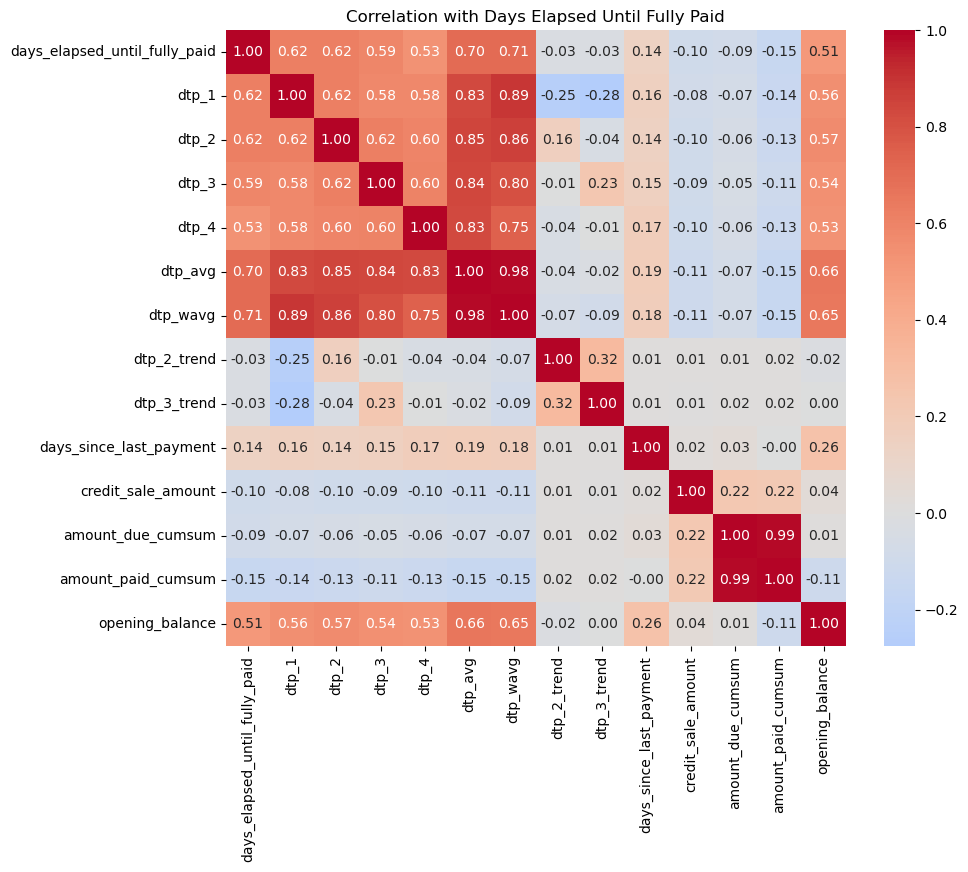

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered = df_credit_sales[df_credit_sales['censor'] == 1]
df_filtered = df_filtered.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4'])

# Select relevant columns
cols = ['days_elapsed_until_fully_paid', 
        'dtp_1', 'dtp_2', 'dtp_3', 'dtp_4', 
        'dtp_avg', 'dtp_wavg', 'dtp_2_trend',
        'dtp_3_trend', 'days_since_last_payment',
        'credit_sale_amount', 'amount_due_cumsum',
        'amount_paid_cumsum', 'opening_balance']

# Compute correlation matrix
corr = df_filtered[cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation with Days Elapsed Until Fully Paid")
plt.show()

# D. Machine Learning Pipelines

## 1. Survival Analysis Sandbox

### a. Step by step pipeline

In [11]:
drop_columns = ['school_year', 'student_id_pseudonimized', 'category_name',
       'gross_receivables', 'amount_discounted', 'adjustments', 'due_date_prev_1',
       'due_date_prev_2', 'date_fully_paid', 'last_payment_date',
       'plan_type_Plan - D', 'plan_type_Plan - E', 'plan_type_nan']

#drop_columns = drop_columns + ['credit_sale_amount', 'amount_due_cumsum', 'amount_paid_cumsum']
drop_columns = drop_columns + ['plan_type_Plan - A', 'plan_type_Plan - B', 'plan_type_Plan - C']

df_data = df_credit_sales[df_credit_sales['censor'] == 1]

df_data = df_data.drop(columns=drop_columns)
df_data.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4'], inplace=True)
df_data

,credit_sale_amount,due_date,days_elapsed_until_fully_paid,dtp_1,dtp_2,dtp_3,dtp_4,dtp_avg,dtp_wavg,dtp_2_trend,dtp_3_trend,days_since_last_payment,amount_due_cumsum,amount_paid_cumsum,opening_balance,dtp_bracket,censor
79,2700.0,2018-06-04,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
80,4500.0,2018-06-04,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
88,2700.0,2018-06-04,365,365,365,365,519,403.5,380.4,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
89,11580.0,2018-06-04,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
112,4500.0,2018-06-15,344,344,276,344,344,327.0,323.6,0.000000,0.000000,15,31002.0,8395.0,22607.0,90_days,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10174,3850.0,2026-07-11,-161,-3,-3,2,3,-0.25,-1.4,0.000000,0.005285,161,223810.0,223810.0,0.0,on_time,1
10175,8300.0,2026-07-11,-162,293,1,260,30,146.0,172.5,-0.555133,-0.031309,145,266474.0,266474.0,0.0,on_time,1
10177,800.0,2026-07-11,-176,-116,-41,-42,2,-49.25,-66.9,0.068244,0.041503,176,345984.0,345984.0,0.0,on_time,1
10178,11920.0,2026-07-11,-166,7,7,-2,-5,1.75,4.0,0.000000,-0.053254,148,248238.0,248238.0,0.0,on_time,1


In [12]:
drop_columns = ['school_year', 'student_id_pseudonimized', 'category_name',
       'gross_receivables', 'amount_discounted', 'adjustments', 'due_date_prev_1',
       'due_date_prev_2', 'date_fully_paid', 'last_payment_date',
       'plan_type_Plan - D', 'plan_type_Plan - E', 'plan_type_nan']

#drop_columns = drop_columns + ['credit_sale_amount', 'amount_due_cumsum', 'amount_paid_cumsum']
drop_columns = drop_columns + ['plan_type_Plan - A', 'plan_type_Plan - B', 'plan_type_Plan - C']

df_data_surv = df_credit_sales.drop(columns=drop_columns)
df_data_surv.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4'], inplace=True)
df_data_surv

,credit_sale_amount,due_date,days_elapsed_until_fully_paid,dtp_1,dtp_2,dtp_3,dtp_4,dtp_avg,dtp_wavg,dtp_2_trend,dtp_3_trend,days_since_last_payment,amount_due_cumsum,amount_paid_cumsum,opening_balance,dtp_bracket,censor
79,2700.0,2018-06-04,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
80,4500.0,2018-06-04,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
88,2700.0,2018-06-04,365,365,365,365,519,403.5,380.4,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
89,11580.0,2018-06-04,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
112,4500.0,2018-06-15,344,344,276,344,344,327.0,323.6,0.000000,0.000000,15,31002.0,8395.0,22607.0,90_days,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10174,3850.0,2026-07-11,-161,-3,-3,2,3,-0.25,-1.4,0.000000,0.005285,161,223810.0,223810.0,0.0,on_time,1
10175,8300.0,2026-07-11,-162,293,1,260,30,146.0,172.5,-0.555133,-0.031309,145,266474.0,266474.0,0.0,on_time,1
10177,800.0,2026-07-11,-176,-116,-41,-42,2,-49.25,-66.9,0.068244,0.041503,176,345984.0,345984.0,0.0,on_time,1
10178,11920.0,2026-07-11,-166,7,7,-2,-5,1.75,4.0,0.000000,-0.053254,148,248238.0,248238.0,0.0,on_time,1


In [13]:
from sklearn.preprocessing import LabelEncoder

target_feature = args.target_feature

label_encoder = LabelEncoder()


df_data_surv[target_feature] = label_encoder.fit_transform(
    df_data_surv[target_feature]
)

X = df_data_surv.drop(columns=[target_feature, 'due_date', 'days_elapsed_until_fully_paid', 'censor'])
T = df_data_surv['days_elapsed_until_fully_paid']
E = df_data_surv['censor']
Y = df_data_surv[target_feature]

# Avoid negative values by shifting by the days of pre-paid period
earliest_pre_payment = np.minimum(T, 0) # Maximum to only get pre-payments
ε = 1e-6 # Used to avoid zero values
T = T - earliest_pre_payment + ε

In [14]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import AdaBoostClassifier
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

from MachineLearning.Utils.generate_survival_features import generate_survival_features

# ============================================
# STEP 0 — Initialize and Prepare Data
# ============================================

# Build survival array
survival_train = np.array(
    [(bool(e), float(t)) for e, t in zip(E.values, T.values)],
    dtype=[('event', 'bool'), ('time', 'float')]
)

# ============================================
# STEP 1 — Tune Survival Model
# ============================================
penalties = [1e-4, 1e-3, 1e-2, 1e-1, 1]
best_penalty, best_c_index = None, -np.inf

for λ in penalties:
    model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[λ])
    model.fit(X, survival_train)
    risk_scores = model.predict(X)
    c_index = concordance_index_censored(E.astype(bool), T, risk_scores)[0]
    if c_index > best_c_index:
        best_penalty, best_c_index = λ, c_index

print("Best Penalty:", best_penalty, "Best C-index:", best_c_index)

# ============================================
# STEP 2 — Retrain Survival Model
# ============================================
survival_model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[best_penalty])
survival_model.fit(X, survival_train)

c:\Users\rjbel\anaconda3\envs\thesis_ippp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Best Penalty: 1 Best C-index: 0.767091634686549


,n_alphas,100
,alphas,[1]
,alpha_min_ratio,'auto'
,l1_ratio,1.0
,penalty_factor,None
,normalize,False
,copy_X,True
,tol,1e-07
,max_iter,100000
,verbose,False
,fit_baseline_model,False


In [15]:
from MachineLearning.Utils.data_preparation_survival_analysis import SurvivalDataPreparer

preparer = SurvivalDataPreparer(df_data,
                                target_feature=args.target_feature,
                                time_feature='days_elapsed_until_fully_paid',
                                censor_feature='censor',
                                test_size=args.test_size)
preparer.prep_data(balance_strategy="borderline_smote")

X_train = preparer.X_train
X_test = preparer.X_test
y_train = preparer.y_train
y_test = preparer.y_test
T_train = preparer.T_train
T_test = preparer.T_test
E_train = preparer.E_train
E_test = preparer.E_test

Partitioning datasets based on due_date...
Applying borderline_smote...


In [16]:
df_survival_train = generate_survival_features(X_train, T_train, E_train, best_penalty)
df_survival_test  = generate_survival_features(X_test, T_test, E_test, best_penalty)

In [17]:
parameters = {
    "learning_rate": 0.1,
    "n_estimators": 50,
    "random_state": 42
}

In [18]:
from MachineLearning.Utils.data_preparation import DataPreparer
from MachineLearning import AdaBoostPipeline

preparer = DataPreparer(df_data, args.target_feature, test_size=args.test_size, verbose=False)
preparer.prep_data(balance_strategy="borderline_smote")

X_train, X_test = preparer.X_train, preparer.X_test
y_train, y_test = preparer.y_train, preparer.y_test

# Drop survival analysis related columns
X_train.drop(columns=["censor", "days_elapsed_until_fully_paid"], inplace=True)
X_test.drop(columns=["censor", "days_elapsed_until_fully_paid"], inplace=True)

pipeline = AdaBoostPipeline(
    X_train, X_test, y_train, y_test,
    args,
    parameters
)

# Capture results from pipeline
result = pipeline.initialize_model().fit(use_feature_selection=True).evaluate().show_results()
result

{'accuracy': 0.773511407902059,
 'precision_macro': 0.6305461152457094,
 'recall_macro': 0.5722354249784445,
 'f1_macro': 0.5849668622183244,
 'roc_auc_macro': 0.8579024815983365}

In [19]:
from MachineLearning.Utils.data_preparation import DataPreparer
from MachineLearning import AdaBoostPipeline

pipeline = AdaBoostPipeline(
    df_survival_train, df_survival_test, y_train, y_test,
    args,
    parameters
)

# Capture results from pipeline
result = pipeline.initialize_model().fit(use_feature_selection=True).evaluate().show_results()
result

{'accuracy': 0.7729549248747913,
 'precision_macro': 0.655723711441957,
 'recall_macro': 0.5835763485181633,
 'f1_macro': 0.5974947364730342,
 'roc_auc_macro': 0.8587921031277452}

In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import AdaBoostClassifier
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

from MachineLearning.Utils.generate_survival_features import generate_survival_features

# ============================================
# STEP 0 — Initialize and Prepare Data
# ============================================

# Build survival array
survival_train = np.array(
    [(bool(e), float(t)) for e, t in zip(E_train.values, T_train.values)],
    dtype=[('event', 'bool'), ('time', 'float')]
)

# ============================================
# STEP 1 — Tune Survival Model
# ============================================
penalties = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
best_penalty, best_c_index = None, -np.inf

for λ in penalties:
    model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[λ])
    model.fit(X_train, survival_train)
    risk_scores = model.predict(X_train)
    c_index = concordance_index_censored(E_train.astype(bool), T_train, risk_scores)[0]
    if c_index > best_c_index:
        best_penalty, best_c_index = λ, c_index

print("Best Penalty:", best_penalty, "Best C-index:", best_c_index)

# ============================================
# STEP 2 — Retrain Survival Model
# ============================================
survival_model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[best_penalty])
survival_model.fit(X_train, survival_train)

# ============================================
# STEP 3 — Generate Survival Features
# ============================================
df_survival_train = generate_survival_features(X_train, T_train, E_train, best_penalty)
df_survival_test  = generate_survival_features(X_test, T_test, E_test, best_penalty)

# ============================================
# STEP 4 — Train Classifier (baseline vs survival)
# ============================================
# Baseline classifier (raw features, full dataset)
baseline_clf = AdaBoostClassifier(**parameters)
baseline_clf.fit(X_train, y_train)
baseline_pred = baseline_clf.predict(X_test)
baseline_f1 = f1_score(y_test, baseline_pred, average="macro")

# Survival-feature classifier (restricted subset)
clf = AdaBoostClassifier(**parameters)
clf.fit(df_survival_train, y_train)
survival_pred = clf.predict(df_survival_test)
survival_f1 = f1_score(y_test, survival_pred, average="macro")

print("Baseline F1:", baseline_f1)
print("Survival F1:", survival_f1)

# ============================================
# STEP 5 — Feature Selection + Final Classifier
# ============================================
selector = SelectFromModel(clf, prefit=True)
X_train_selected = selector.transform(df_survival_train)
X_test_selected  = selector.transform(df_survival_test)

final_clf = AdaBoostClassifier(**parameters)
final_clf.fit(X_train_selected, y_train)
final_pred = final_clf.predict(X_test_selected)
final_f1 = f1_score(y_test, final_pred, average="macro")

print("Final F1 Score:", final_f1)

Best Penalty: 1 Best C-index: 0.7161230341806691
Baseline F1: 0.5849668622183244
Survival F1: 0.5974947364730342
Final F1 Score: 0.5978347645264752


c:\Users\rjbel\anaconda3\envs\thesis_ippp\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\rjbel\anaconda3\envs\thesis_ippp\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [21]:
df_survival_train

,credit_sale_amount,dtp_1,dtp_2,dtp_3,dtp_4,dtp_avg,dtp_wavg,dtp_2_trend,dtp_3_trend,days_since_last_payment,...,surv_prob_60,surv_prob_90,surv_prob_120,cum_hazard_30,cum_hazard_60,cum_hazard_90,cum_hazard_120,expected_survival_time,partial_hazard,log_partial_hazard
0,2700.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,0.000000,0.000000,-1.000000,...,0.724967,0.681913,0.640532,0.146769,0.321630,0.382853,0.445456,329.213561,0.226614,0.204257
1,4500.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,0.000000,0.000000,-1.000000,...,0.716157,0.672061,0.629777,0.152348,0.333856,0.397407,0.462390,317.744275,0.235228,0.211256
2,2700.000000,365.000000,365.000000,365.000000,519.000000,403.500000,380.400000,0.000000,0.000000,-1.000000,...,0.745245,0.704678,0.665479,0.134180,0.294042,0.350014,0.407248,357.550468,0.207176,0.188284
3,11580.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,0.000000,0.000000,-1.000000,...,0.679344,0.631143,0.585390,0.176429,0.386627,0.460223,0.535478,274.659644,0.272410,0.240913
4,4500.000000,344.000000,276.000000,344.000000,344.000000,327.000000,323.600000,0.000000,0.000000,15.000000,...,0.644947,0.593289,0.544743,0.200140,0.438587,0.522073,0.607441,240.464071,0.309019,0.269278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5711,3466.092289,133.164427,32.786215,45.805783,58.788551,67.636244,78.141647,-3.919534,-0.859665,64.985105,...,0.305977,0.244223,0.193945,0.540405,1.184247,1.409672,1.640179,68.639681,0.834397,0.606716
5712,4169.243196,136.154283,133.635286,146.872020,219.066604,158.932049,145.833364,-1.328221,0.114524,14.501461,...,0.384170,0.320211,0.265807,0.436556,0.956671,1.138776,1.324986,92.208581,0.674051,0.515246
5713,2847.557113,15.158432,164.317495,-1.035921,3.107764,45.386943,55.462214,4.506083,-0.159983,23.078901,...,0.201054,0.148148,0.108415,0.732034,1.604182,1.909543,2.221788,44.232824,1.130275,0.756251
5714,2333.032347,65.389378,5.954191,75.198339,19.805311,41.586805,44.962207,-0.532152,-0.022147,15.517178,...,0.223431,0.167977,0.125477,0.683879,1.498655,1.783928,2.075632,48.904634,1.055922,0.720724


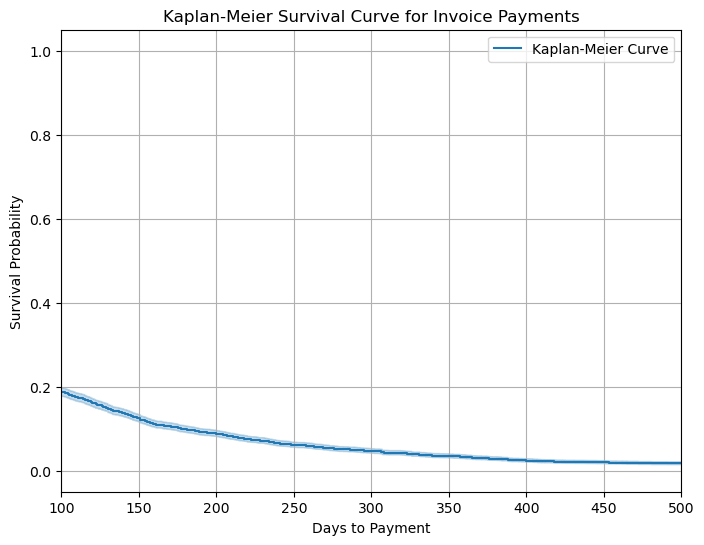

In [22]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# ============================================
# STEP X — Plot Kaplan-Meier Survival Curve
# ============================================

# Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the model on your training data
kmf.fit(durations=T_train,
        event_observed=E_train,
        label="Kaplan-Meier Curve")

# Plot the survival function
plt.figure(figsize=(8,6))
kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Curve for Invoice Payments")
plt.xlabel("Days to Payment")
plt.ylabel("Survival Probability")
plt.xlim(100, 500)
plt.grid(True)
plt.show()

### b. Unedited full pipeline

In [23]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

# ============================================
# STEP 0 — Prepare Data
# ============================================
# X: feature matrix (DataFrame)
# T: time-to-event (array)
# E: event indicator (array, 1=event occurred, 0=censored)
# Y: classification labels (array)


# Convert to structured array for scikit-survival
survival_data = np.array([(bool(e), t) for e, t in zip(E, T)],
                         dtype=[('event', 'bool'), ('time', 'float')])

# ============================================
# STEP 1 — Define Candidate Penalties
# ============================================
penalties = [1e-4, 1e-3, 1e-2, 1e-1, 1]

best_penalty = None
best_c_index = -np.inf

# ============================================
# STEP 2 — Tune Survival Model
# ============================================
for λ in penalties:
    model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[λ])
    model.fit(X, survival_data)
    
    risk_scores = model.predict(X)
    c_index = concordance_index_censored(E.astype(bool), T, risk_scores)[0]
    
    if c_index > best_c_index:
        best_c_index = c_index
        best_penalty = λ

print("Best Penalty:", best_penalty, "Best C-index:", best_c_index)

# ============================================
# STEP 3 — Retrain Survival Model
# ============================================
survival_model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[best_penalty])
survival_model.fit(X, survival_data)

# ============================================
# STEP 4 — Generate Survival-Based Features
# ============================================
df_survival = generate_survival_features(X, T, E, best_penalty)

# ============================================
# STEP 5 — Train Initial Classifier
# ============================================
clf = RandomForestClassifier(random_state=42)
clf.fit(df_survival, Y)

# Evaluate initial classifier
Y_pred_initial = clf.predict(df_survival)
f1_initial = f1_score(Y, Y_pred_initial, average="macro")
print("Initial F1 Score:", f1_initial)

# ============================================
# STEP 6 — Feature Selection
# ============================================
selector = SelectFromModel(clf, prefit=True)
X_selected = selector.transform(df_survival)

# ============================================
# STEP 7 — Train Final Classifier
# ============================================
final_clf = RandomForestClassifier(random_state=42)
final_clf.fit(X_selected, Y)

# ============================================
# STEP 8 — Predictions
# ============================================
Y_pred_final = final_clf.predict(X_selected)
f1_final = f1_score(Y, Y_pred_final, average="macro")

print("Final F1 Score:", f1_final)


Best Penalty: 1 Best C-index: 0.767091634686549
Initial F1 Score: 1.0


c:\Users\rjbel\anaconda3\envs\thesis_ippp\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Final F1 Score: 1.0


## 2. Enhanced with Survival Features

### a. Calculating the best penalty (λ) 

In [24]:
drop_columns = ['school_year', 'student_id_pseudonimized', 'category_name',
       'gross_receivables', 'amount_discounted', 'adjustments', 'due_date_prev_1',
       'due_date_prev_2', 'date_fully_paid', 'last_payment_date']

drop_columns = drop_columns + ['plan_type_Plan - A', 'plan_type_Plan - B', 'plan_type_Plan - C',
                               'plan_type_Plan - D', 'plan_type_Plan - E', 'plan_type_nan']

df_data_surv = df_credit_sales.drop(columns=drop_columns)
df_data_surv.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4'], inplace=True)
df_data_surv

,credit_sale_amount,due_date,days_elapsed_until_fully_paid,dtp_1,dtp_2,dtp_3,dtp_4,dtp_avg,dtp_wavg,dtp_2_trend,dtp_3_trend,days_since_last_payment,amount_due_cumsum,amount_paid_cumsum,opening_balance,dtp_bracket,censor
79,2700.0,2018-06-04,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
80,4500.0,2018-06-04,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
88,2700.0,2018-06-04,365,365,365,365,519,403.5,380.4,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
89,11580.0,2018-06-04,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
112,4500.0,2018-06-15,344,344,276,344,344,327.0,323.6,0.000000,0.000000,15,31002.0,8395.0,22607.0,90_days,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10174,3850.0,2026-07-11,-161,-3,-3,2,3,-0.25,-1.4,0.000000,0.005285,161,223810.0,223810.0,0.0,on_time,1
10175,8300.0,2026-07-11,-162,293,1,260,30,146.0,172.5,-0.555133,-0.031309,145,266474.0,266474.0,0.0,on_time,1
10177,800.0,2026-07-11,-176,-116,-41,-42,2,-49.25,-66.9,0.068244,0.041503,176,345984.0,345984.0,0.0,on_time,1
10178,11920.0,2026-07-11,-166,7,7,-2,-5,1.75,4.0,0.000000,-0.053254,148,248238.0,248238.0,0.0,on_time,1


In [25]:
from sklearn.preprocessing import LabelEncoder

target_feature = args.target_feature

# Encode the labels
label_encoder = LabelEncoder()
df_data_surv[target_feature] = label_encoder.fit_transform(
    df_data_surv[target_feature]
)

# Extract variables for training the survival model
X = df_data_surv.drop(columns=[target_feature, 'due_date', 'days_elapsed_until_fully_paid', 'censor'])
T = df_data_surv['days_elapsed_until_fully_paid']
E = df_data_surv['censor']
Y = df_data_surv[target_feature]

# Avoid negative values by shifting by the days of pre-paid period
earliest_pre_payment = np.minimum(T, 0) # Maximum to only get pre-payments
ε = 1e-6 # Used to avoid zero values
T = T - earliest_pre_payment + ε

In [26]:
import numpy as np
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

from MachineLearning.Utils.generate_survival_features import generate_survival_features

# ============================================
# STEP 0 — Initialize and Prepare Data
# ============================================

# Build survival array
survival_train = np.array(
    [(bool(e), float(t)) for e, t in zip(E.values, T.values)],
    dtype=[('event', 'bool'), ('time', 'float')]
)

# ============================================
# STEP 1 — Tune Survival Model
# ============================================
penalties = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
best_penalty, best_c_index = None, -np.inf

for λ in penalties:
    model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[λ], normalize=True)
    model.fit(X, survival_train)
    risk_scores = model.predict(X)
    c_index = concordance_index_censored(E.astype(bool), T, risk_scores)[0]
    if c_index > best_c_index:
        best_penalty, best_c_index = λ, c_index

print(f"Best Penalty: {best_penalty} | Best C-index: {best_c_index}")

# ============================================
# STEP 2 — Retrain Survival Model
# ============================================
survival_model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[best_penalty])
survival_model.fit(X, survival_train)

C:\Users\rjbel\AppData\Local\Temp\ipykernel_41092\1403656795.py:25: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X, survival_train)
C:\Users\rjbel\AppData\Local\Temp\ipykernel_41092\1403656795.py:25: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X, survival_train)
C:\Users\rjbel\AppData\Local\Temp\ipykernel_41092\1403656795.py:25: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X, survival_train)


Best Penalty: 0.001 | Best C-index: 0.7793153818936158


,n_alphas,100
,alphas,[0.001]
,alpha_min_ratio,'auto'
,l1_ratio,1.0
,penalty_factor,None
,normalize,False
,copy_X,True
,tol,1e-07
,max_iter,100000
,verbose,False
,fit_baseline_model,False


### b. Hyperparameter tuning (various balancing strategies, parameters, and models)

In [27]:
from MachineLearning import (
    AdaBoostPipeline,
    DecisionTreePipeline,
    GaussianNaiveBayesPipeline,
    KnearestNeighborPipeline,
    RandomForestPipeline,
    XGboostPipeline,
    MultiLayerPerceptronPipeline,
    TransformerPipeline,
)

models = {
    "ada_boost": AdaBoostPipeline,
    "decision_tree": DecisionTreePipeline,
    "gaussian_naive_bayes": GaussianNaiveBayesPipeline,
    "knn": KnearestNeighborPipeline,
    "random_forest": RandomForestPipeline,
    "xgboost": XGboostPipeline,
    #"nn_mlp": MultiLayerPerceptronPipeline,
    #"nn_rnn": RecurrentNeuralNetworkPipeline,
    #"nn_transformer": TransformerPipeline
}

# Since these models are trained in the GPU, it's best
# to not to parallel compute to avoid bugs
do_not_parallel_compute = ['xg_boost', 'nn_mlp', 'nn_transformer']

In [28]:
from MachineLearning.Utils.generate_thresholds import generate_thresholds

balance_strategies = ["smote", "borderline_smote", "smoteenn", "smotetomek", "hybrid"]
thresholds = generate_thresholds(min_threshold=0.5, max_threshold=0.9, step=0.1)

In [29]:
# To silence the error when running knn:
# UserWarning: Could not find the number of physical cores for the following reason:
# [WinError 2]
import os

os.environ['OMP_NUM_THREADS'] = '16'

In [30]:
# Older method used to debug if there are any changes in the model's code
if False:
    from MachineLearning.Utils.run_models_single_threaded import run_survival_model_experiments

    df_results = run_survival_model_experiments(df_data_surv, models, balance_strategies, args, best_penalty, thresholds)

In [31]:
# Helper columns
drop_columns = ['school_year', 'student_id_pseudonimized', 'category_name',
       'gross_receivables', 'amount_discounted', 'adjustments', 'due_date_prev_1',
       'due_date_prev_2', 'date_fully_paid', 'last_payment_date']

drop_columns = drop_columns + ['plan_type_Plan - A', 'plan_type_Plan - B', 'plan_type_Plan - C',
                               'plan_type_Plan - D', 'plan_type_Plan - E', 'plan_type_nan']

# Only extract invoices with payments
df_data = df_credit_sales[df_credit_sales['censor'] == 1]

df_data = df_data.drop(columns=drop_columns)

# Drop invoices with missing critical features
df_data.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4'], inplace=True)
df_data

,credit_sale_amount,due_date,days_elapsed_until_fully_paid,dtp_1,dtp_2,dtp_3,dtp_4,dtp_avg,dtp_wavg,dtp_2_trend,dtp_3_trend,days_since_last_payment,amount_due_cumsum,amount_paid_cumsum,opening_balance,dtp_bracket,censor
79,2700.0,2018-06-04,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
80,4500.0,2018-06-04,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
88,2700.0,2018-06-04,365,365,365,365,519,403.5,380.4,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
89,11580.0,2018-06-04,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
112,4500.0,2018-06-15,344,344,276,344,344,327.0,323.6,0.000000,0.000000,15,31002.0,8395.0,22607.0,90_days,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10174,3850.0,2026-07-11,-161,-3,-3,2,3,-0.25,-1.4,0.000000,0.005285,161,223810.0,223810.0,0.0,on_time,1
10175,8300.0,2026-07-11,-162,293,1,260,30,146.0,172.5,-0.555133,-0.031309,145,266474.0,266474.0,0.0,on_time,1
10177,800.0,2026-07-11,-176,-116,-41,-42,2,-49.25,-66.9,0.068244,0.041503,176,345984.0,345984.0,0.0,on_time,1
10178,11920.0,2026-07-11,-166,7,7,-2,-5,1.75,4.0,0.000000,-0.053254,148,248238.0,248238.0,0.0,on_time,1


In [ ]:
from MachineLearning.Utils.run_models_parallel import SurvivalExperimentRunner

# Create an experiment runner instance
runner = SurvivalExperimentRunner(
    df_data_surv=df_data,
    models=models,
    balance_strategies=balance_strategies,
    args=args,
    best_penalty=best_penalty,
    thresholds=thresholds,
    n_jobs=-1,
    output_path="MachineLearning/Results/model_results.xlsx",
    do_not_parallel_compute=do_not_parallel_compute,
    feature_selection=True
)

# Run experiments
df_results = runner.run()

Running parallel experiments:  35%|███▌      | 181/513 [12:52<42:19,  7.65s/exp]  

In [ ]:
df_results.sort_values(by='enhanced_accuracy', ascending=False)

In [ ]:
df_results.sort_values(by='enhanced_precision_macro', ascending=False)

In [ ]:
df_results.sort_values(by='enhanced_f1_macro', ascending=False)

In [ ]:
df_results.sort_values(by='enhanced_roc_auc_macro', ascending=False)

In [ ]:
import pandas as pd

# File path
file_path = r"C:\Users\rjbel\Python\Notebooks\Mapua\Thesis\MachineLearning\Results\06 model_results - no feature selection.xlsx"

# Read the Excel file
df = pd.read_excel(file_path)

# Choose which score column to use
score_column = "enhanced_roc_auc_macro"   # <-- change this to the metric you want (e.g., "f1", "roc_auc", etc.)

# Create a combined column: balance_strategy + threshold (only for hybrid)
df["balance_strategy_full"] = df.apply(
    lambda row: f"{row['balance_strategy']}_{row['undersample_threshold']}"
    if row["balance_strategy"] == "hybrid" else row["balance_strategy"],
    axis=1
)

# Compute mean score per model+parameters+strategy
grouped = (
    df.groupby(["model", "parameters", "balance_strategy_full"])[score_column]
    .mean()
    .reset_index()
)

# Rank strategies within each model+parameters group
grouped["rank"] = grouped.groupby(["model", "parameters"])[score_column] \
                         .rank(method="first", ascending=False)

# Assign weighted points: top 1 → 5, top 2 → 4, … top 5 → 1
def assign_points(rank):
    if rank == 1: return 5
    elif rank == 2: return 4
    elif rank == 3: return 3
    elif rank == 4: return 2
    elif rank == 5: return 1
    else: return 0

grouped["points"] = grouped["rank"].apply(assign_points)

# Aggregate across all models to see total points per strategy
strategy_scores = (
    grouped.groupby("balance_strategy_full")["points"]
    .sum()
    .reset_index()
    .sort_values("points", ascending=False)
)

# Show results
print("Weighted ranking per model+parameters:")
print(grouped.sort_values(["model", "parameters", "rank"]))

print("\nGlobal tally of weighted points per balance strategy:")
print(strategy_scores)